## 100kmあたりのガソリン消費量の予測

### 0. データについて
- 使用するデータはKaggleの"Car Fuel Consumption"
##### 参考)https://www.kaggle.com/anderas/car-consume


- *note) E10の方が安価 E10 : 1.379€, SP98 : 1.459€*


|データ名|単位|意味|
|:-|:-|:-|
|distance|km|給油までの走行距離|
|consume|L/100km|100kmあたりのガソリン消費量|
|speed|km/h|平均速度|
|temp_inside|℃|車内設定温度|
|temp_outside|℃|給油時の外気温|
|specials|N/A|雨、雪、エアコンONのremark|
|gas_type|N/A|走行開始前に給油した油種（E10 or SP98)|
|AC|N/A|ONなら1。OFFなら0。|
|rain|N/A|雨か雪なら1。晴れなら0。|
|sun|N/A|晴れなら1。雨か雪なら0。|
|refill liters|L|給油した際の給油量|
|refill gas|N/A|給油した際の油種|

### 1. データの確認

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3D散布図の描画
%matplotlib inline

In [2]:
car = pd.read_csv("./DATA/measurements.csv",decimal=',') #データCSVの読み込み。decimalでカンマを変換

In [3]:
#データ確認
display(car.head())
car.info()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float64
 1   consume        388 non-null    float64
 2   speed          388 non-null    int64  
 3   temp_inside    376 non-null    float64
 4   temp_outside   388 non-null    int64  
 5   specials       93 non-null     object 
 6   gas_type       388 non-null    object 
 7   AC             388 non-null    int64  
 8   rain           388 non-null    int64  
 9   sun            388 non-null    int64  
 10  refill liters  13 non-null     float64
 11  refill gas     13 non-null     object 
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [4]:
#欠損値数確認
print(car["temp_inside"].isnull().sum())
print(car["refill liters"].isnull().sum())

12
375


In [5]:
car.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


### データについて分かったこと
- "temp_inside"に欠損値有り  
- "specials", "refill liters", "refill gas"は意味的に説明変数にならなそう。"refiill liters"と"refill gas"は次の走行に関する説明変数
- "gas_type"が文字列
- 値のスケールがバラバラ

### 2. 前処理
    1) temp_insideの前処理

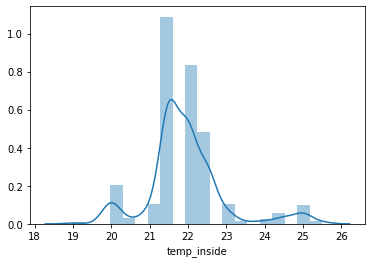

In [6]:
sns.distplot(car["temp_inside"], bins=20)
plt.show()

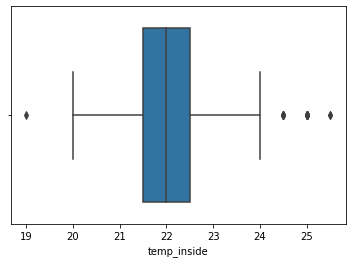

In [7]:
sns.boxplot(car["temp_inside"])
plt.show()

In [8]:
car["temp_inside"].value_counts()

21.5    133
22.0    102
22.5     59
20.0     25
23.0     13
21.0     13
25.0     12
24.5      7
20.5      4
24.0      3
25.5      2
23.5      2
19.0      1
Name: temp_inside, dtype: int64

- 19～25.5℃で分布しており異常値や外れ値もなさそう。
- 平均値で補完して良さそう

In [9]:
temp_inside_mod = car["temp_inside"].dropna() #NaNを削除
temp_inside_avg = temp_inside_mod.mean() #平均値算出
car["temp_inside"] = car["temp_inside"].fillna(temp_inside_avg)
car["temp_inside"].value_counts() #AVE 21.92...が入っているか？

21.500000    133
22.000000    102
22.500000     59
20.000000     25
23.000000     13
21.000000     13
21.929521     12
25.000000     12
24.500000      7
20.500000      4
24.000000      3
25.500000      2
23.500000      2
19.000000      1
Name: temp_inside, dtype: int64

    2) gas_typeの前処理

In [10]:
car["gas_type"].value_counts()

SP98    228
E10     160
Name: gas_type, dtype: int64

In [11]:
#SP98を0, E10を1に置換
car.loc[car["gas_type"]=="SP98", "gas_type"]=0
car.loc[car["gas_type"]=="E10", "gas_type"]=1
car["gas_type"]=car["gas_type"].astype(float)

    3) 不要列の削除
    - "specials", "refill liters", "refill gas"を削除

In [12]:
#使う変数だけでdf_carを作成
drop_columns = ["specials", "refill liters", "refill gas"]
df_car=car.drop(drop_columns, axis=1)

In [13]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   distance      388 non-null    float64
 1   consume       388 non-null    float64
 2   speed         388 non-null    int64  
 3   temp_inside   388 non-null    float64
 4   temp_outside  388 non-null    int64  
 5   gas_type      388 non-null    float64
 6   AC            388 non-null    int64  
 7   rain          388 non-null    int64  
 8   sun           388 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 27.4 KB


### 3. データの可視化

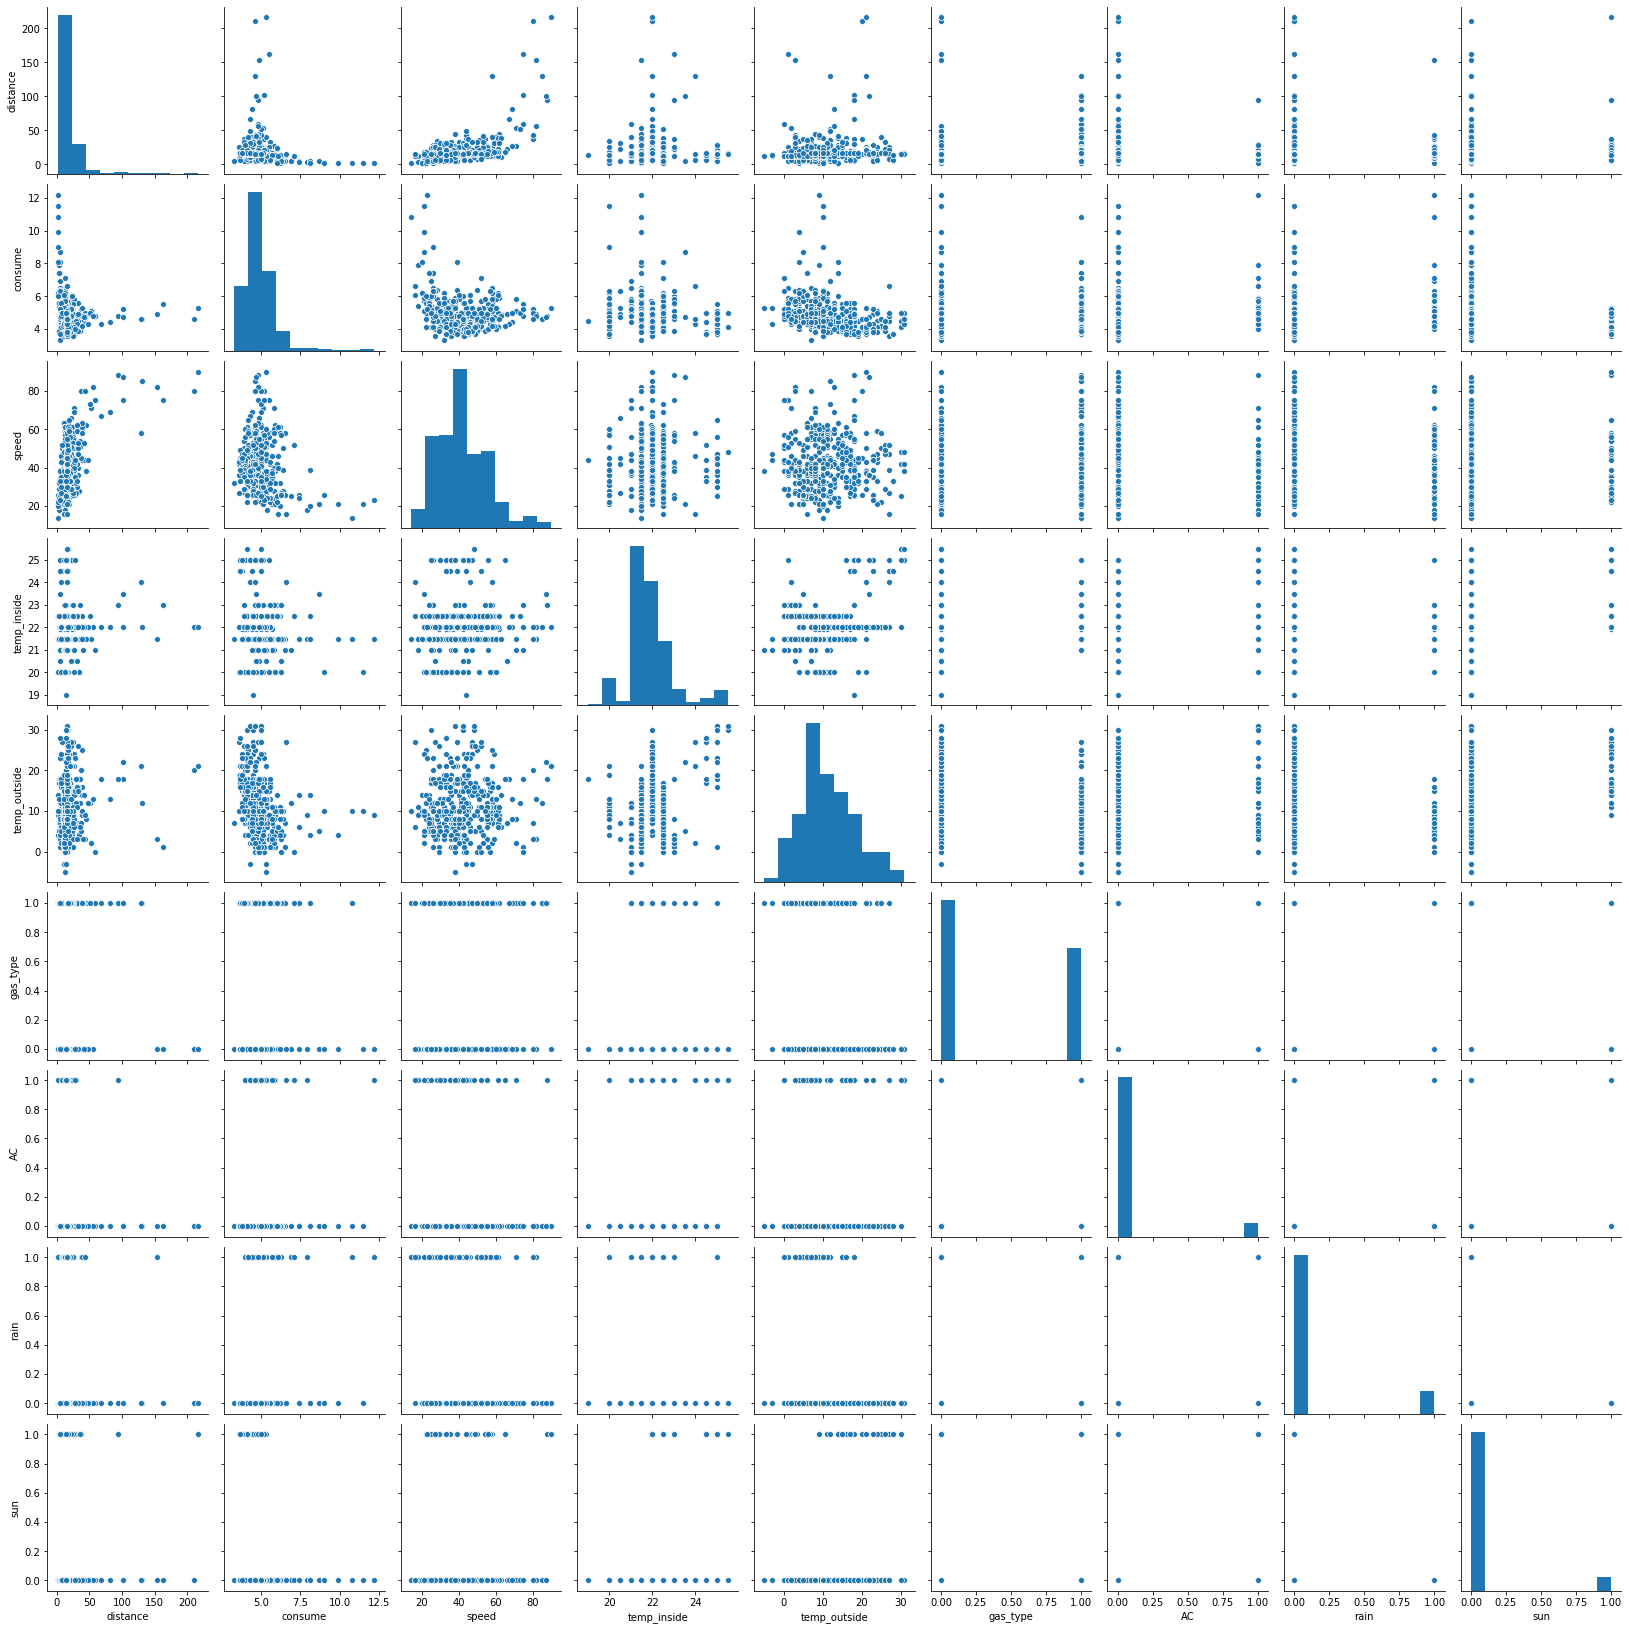

In [14]:
sns.pairplot(df_car)
plt.show()

In [15]:
df_car.corr()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,0.053411,-0.025738,-0.019791,0.081120
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.015327,0.096591,0.248118,-0.170667
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,0.097360,-0.035408,0.009489,0.081618
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,-0.010198,0.297376,-0.036937,0.242248
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,-0.148705,0.167562,-0.186315,0.346903
gas_type,0.053411,0.015327,0.097360,-0.010198,-0.148705,1.000000,-0.105285,-0.060328,-0.022761
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,-0.105285,1.000000,0.242915,0.088598
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,-0.060328,0.242915,1.000000,-0.112650
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,-0.022761,0.088598,-0.112650,1.000000


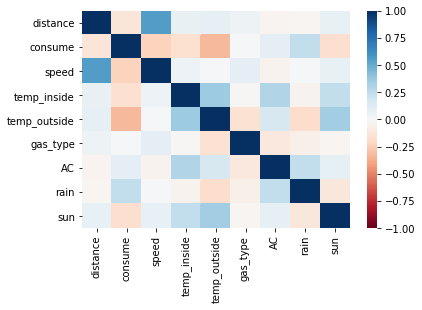

In [16]:
sns.heatmap(df_car.corr(),cmap='RdBu',vmin=-1,vmax=1)
plt.show()

### 4. 線形回帰モデル作成
- note) Day1では線形回帰にてモデル作成　訓練誤差はMSE = 0.845、RMSE = 0.919、MAE = 0.618

- 線形回帰モデルを交差検証法にて評価
- 説明変数は標準化しておく

In [17]:
# 変数の設定
y = df_car["consume"].values
X = df_car[["distance", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun", "gas_type"]].values

In [18]:
print(y.shape)
print(X.shape)

(388,)
(388, 8)


In [19]:
#交差検証法
from sklearn.model_selection import KFold # 交差検証法に関する関数

n_split = 5 # グループ数を設定（5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    #訓練データの説明変数を標準化
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    stdsc = StandardScaler()
    X_train_std= stdsc.fit_transform(X_train)
    
    #テストデータの説明変数を標準化
    X_test_std= stdsc.transform(X_test)   

    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train_std, y_train)

    # 予測を実行
    y_pred_train = regr.predict(X_train_std)
    y_pred_test = regr.predict(X_test_std)
    
    # テストデータに対するMAEを計算
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE_train = %s"%round(mae_train, 3))
    print("MAE_test  = %s"%round(mae_test, 3))
    print()
    
    cross_valid_mae += mae_test #後で平均を取るためにMAEを加算
    split_num += 1

Fold 1
MAE_train = 0.616
MAE_test  = 0.666

Fold 2
MAE_train = 0.629
MAE_test  = 0.619

Fold 3
MAE_train = 0.568
MAE_test  = 0.742

Fold 4
MAE_train = 0.625
MAE_test  = 0.61

Fold 5
MAE_train = 0.65
MAE_test  = 0.518



In [20]:
# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Cross Validation MAE = 0.631


### 訓練誤差と汎化誤差に大きく差はなくオーバーフィッティングは起こっていない
### 正則化は不要

### ただし、consume平均が約4.91Lなので誤差0.631は大きい（平均値に対し約12%の誤差）

### ５．ランダムフォレスト

In [21]:
from sklearn.ensemble import RandomForestRegressor as RFR

#交差検証法
from sklearn.model_selection import KFold # 交差検証法に関する関数

n_split = 5 # グループ数を設定（5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    #訓練データの説明変数を標準化
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    stdsc = StandardScaler()
    X_train_std= stdsc.fit_transform(X_train)
    
    #テストデータの説明変数を標準化
    X_test_std= stdsc.transform(X_test)   

    # 学習用データを使ってランダムフォレストモデルを学習
    regr = RFR(n_jobs=-1, random_state=1234)
    regr.fit(X_train_std, y_train)
    
    # 予測を実行
    y_pred_train = regr.predict(X_train_std)
    y_pred_test = regr.predict(X_test_std)
    
    # テストデータに対するMAEを計算
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE_train = %s"%round(mae_train, 3))
    print("MAE_test  = %s"%round(mae_test, 3))
    print()
    
    cross_valid_mae += mae_test #後で平均を取るためにMAEを加算
    split_num += 1
    
# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE_train = 0.162
MAE_test  = 0.464

Fold 2
MAE_train = 0.172
MAE_test  = 0.39

Fold 3
MAE_train = 0.155
MAE_test  = 0.521

Fold 4
MAE_train = 0.158
MAE_test  = 0.467

Fold 5
MAE_train = 0.168
MAE_test  = 0.361

Cross Validation MAE = 0.44


In [22]:
#ランダムフォレストの条件を確認
print(regr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)


### 訓練誤差と汎化誤差に差があり過学習がおきている
### 条件を変更？
・criterionはMSEよりMAE？
・nodeやdeepthを減らす？

### ただし、MAEが0.44と線形回帰よりは改善

### ６．ニューラルネットワーク

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

Train on 310 samples, validate on 78 samples
Epoch 1/500
310/310 [==============================] - 0s 284us/sample - loss: 19.5295 - mean_absolute_error: 4.2364 - val_loss: 11.5107 - val_mean_absolute_error: 3.1782
Epoch 2/500
310/310 [==============================] - 0s 52us/sample - loss: 8.9864 - mean_absolute_error: 2.6251 - val_loss: 5.1506 - val_mean_absolute_error: 1.6253
Epoch 3/500
310/310 [==============================] - 0s 52us/sample - loss: 3.5851 - mean_absolute_error: 1.2718 - val_loss: 2.9357 - val_mean_absolute_error: 1.1301
Epoch 4/500
310/310 [==============================] - 0s 52us/sample - loss: 2.2090 - mean_absolute_error: 0.9893 - val_loss: 2.1277 - val_mean_absolute_error: 1.0481
Epoch 5/500
310/310 [==============================] - 0s 52us/sample - loss: 1.7889 - mean_absolute_error: 0.9007 - val_loss: 1.5772 - val_mean_absolute_error: 0.9122
Epoch 6/500
310/310 [==============================] - 0s 52us/sample - loss: 1.5723 - mean_absolute_error: 0.82

310/310 [==============================] - 0s 52us/sample - loss: 0.4785 - mean_absolute_error: 0.4838 - val_loss: 0.7411 - val_mean_absolute_error: 0.6480
Epoch 50/500
310/310 [==============================] - 0s 52us/sample - loss: 0.4426 - mean_absolute_error: 0.4643 - val_loss: 0.7077 - val_mean_absolute_error: 0.6298
Epoch 51/500
310/310 [==============================] - 0s 26us/sample - loss: 0.4393 - mean_absolute_error: 0.4664 - val_loss: 0.7010 - val_mean_absolute_error: 0.6251
Epoch 52/500
310/310 [==============================] - 0s 52us/sample - loss: 0.4409 - mean_absolute_error: 0.4810 - val_loss: 0.6771 - val_mean_absolute_error: 0.6140
Epoch 53/500
310/310 [==============================] - 0s 52us/sample - loss: 0.4669 - mean_absolute_error: 0.4753 - val_loss: 0.7725 - val_mean_absolute_error: 0.6588
Epoch 54/500
310/310 [==============================] - 0s 52us/sample - loss: 0.4270 - mean_absolute_error: 0.4728 - val_loss: 0.7162 - val_mean_absolute_error: 0.6250

310/310 [==============================] - 0s 52us/sample - loss: 0.3105 - mean_absolute_error: 0.4227 - val_loss: 0.9554 - val_mean_absolute_error: 0.6835
Epoch 98/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2914 - mean_absolute_error: 0.4111 - val_loss: 0.9894 - val_mean_absolute_error: 0.7119
Epoch 99/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2905 - mean_absolute_error: 0.4059 - val_loss: 0.9986 - val_mean_absolute_error: 0.7110
Epoch 100/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2948 - mean_absolute_error: 0.4111 - val_loss: 1.0300 - val_mean_absolute_error: 0.7319
Epoch 101/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2860 - mean_absolute_error: 0.4059 - val_loss: 1.1027 - val_mean_absolute_error: 0.7381
Epoch 102/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2948 - mean_absolute_error: 0.4225 - val_loss: 0.8674 - val_mean_absolute_error: 0.6

310/310 [==============================] - 0s 52us/sample - loss: 0.2675 - mean_absolute_error: 0.3858 - val_loss: 1.3567 - val_mean_absolute_error: 0.8126
Epoch 145/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2668 - mean_absolute_error: 0.3902 - val_loss: 1.1283 - val_mean_absolute_error: 0.7305
Epoch 146/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2845 - mean_absolute_error: 0.4051 - val_loss: 1.2201 - val_mean_absolute_error: 0.7547
Epoch 147/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2669 - mean_absolute_error: 0.3800 - val_loss: 1.2624 - val_mean_absolute_error: 0.7820
Epoch 148/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2806 - mean_absolute_error: 0.3979 - val_loss: 1.0424 - val_mean_absolute_error: 0.6930
Epoch 149/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2930 - mean_absolute_error: 0.4100 - val_loss: 1.4226 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.2488 - mean_absolute_error: 0.3665 - val_loss: 1.1529 - val_mean_absolute_error: 0.7404
Epoch 192/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2361 - mean_absolute_error: 0.3544 - val_loss: 1.3112 - val_mean_absolute_error: 0.7986
Epoch 193/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2447 - mean_absolute_error: 0.3664 - val_loss: 1.1052 - val_mean_absolute_error: 0.7163
Epoch 194/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2750 - mean_absolute_error: 0.3875 - val_loss: 1.4763 - val_mean_absolute_error: 0.8468
Epoch 195/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2587 - mean_absolute_error: 0.3699 - val_loss: 1.1649 - val_mean_absolute_error: 0.7577
Epoch 196/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2467 - mean_absolute_error: 0.3653 - val_loss: 1.1448 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 26us/sample - loss: 0.2317 - mean_absolute_error: 0.3548 - val_loss: 1.1444 - val_mean_absolute_error: 0.7483
Epoch 239/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2380 - mean_absolute_error: 0.3630 - val_loss: 1.2031 - val_mean_absolute_error: 0.7560
Epoch 240/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2334 - mean_absolute_error: 0.3477 - val_loss: 1.1947 - val_mean_absolute_error: 0.7706
Epoch 241/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2226 - mean_absolute_error: 0.3413 - val_loss: 1.1603 - val_mean_absolute_error: 0.7444
Epoch 242/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2202 - mean_absolute_error: 0.3371 - val_loss: 1.1129 - val_mean_absolute_error: 0.7326
Epoch 243/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2287 - mean_absolute_error: 0.3472 - val_loss: 1.1083 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.2515 - mean_absolute_error: 0.3720 - val_loss: 1.2517 - val_mean_absolute_error: 0.8097
Epoch 286/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2564 - mean_absolute_error: 0.3794 - val_loss: 1.0919 - val_mean_absolute_error: 0.7179
Epoch 287/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2410 - mean_absolute_error: 0.3724 - val_loss: 1.0538 - val_mean_absolute_error: 0.7265
Epoch 288/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2258 - mean_absolute_error: 0.3626 - val_loss: 1.0972 - val_mean_absolute_error: 0.7161
Epoch 289/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2229 - mean_absolute_error: 0.3526 - val_loss: 0.9863 - val_mean_absolute_error: 0.7017
Epoch 290/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2108 - mean_absolute_error: 0.3393 - val_loss: 1.0831 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.2179 - mean_absolute_error: 0.3485 - val_loss: 1.0924 - val_mean_absolute_error: 0.7497
Epoch 334/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1992 - mean_absolute_error: 0.3297 - val_loss: 1.0547 - val_mean_absolute_error: 0.7509
Epoch 335/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1989 - mean_absolute_error: 0.3248 - val_loss: 1.0343 - val_mean_absolute_error: 0.7350
Epoch 336/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1836 - mean_absolute_error: 0.3249 - val_loss: 1.0826 - val_mean_absolute_error: 0.7537
Epoch 337/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2018 - mean_absolute_error: 0.3343 - val_loss: 1.0009 - val_mean_absolute_error: 0.7344
Epoch 338/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1805 - mean_absolute_error: 0.3136 - val_loss: 1.1830 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.1953 - mean_absolute_error: 0.3329 - val_loss: 1.1852 - val_mean_absolute_error: 0.8116
Epoch 381/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1851 - mean_absolute_error: 0.3216 - val_loss: 0.9300 - val_mean_absolute_error: 0.7041
Epoch 382/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1878 - mean_absolute_error: 0.3229 - val_loss: 1.0801 - val_mean_absolute_error: 0.7692
Epoch 383/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1869 - mean_absolute_error: 0.3231 - val_loss: 1.0377 - val_mean_absolute_error: 0.7372
Epoch 384/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2010 - mean_absolute_error: 0.3366 - val_loss: 1.0223 - val_mean_absolute_error: 0.7497
Epoch 385/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2049 - mean_absolute_error: 0.3334 - val_loss: 1.0555 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.1709 - mean_absolute_error: 0.3023 - val_loss: 1.2329 - val_mean_absolute_error: 0.7929
Epoch 428/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1843 - mean_absolute_error: 0.3070 - val_loss: 1.0996 - val_mean_absolute_error: 0.7414
Epoch 429/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1743 - mean_absolute_error: 0.3033 - val_loss: 1.1788 - val_mean_absolute_error: 0.7861
Epoch 430/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1770 - mean_absolute_error: 0.2995 - val_loss: 1.2437 - val_mean_absolute_error: 0.7998
Epoch 431/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1861 - mean_absolute_error: 0.3255 - val_loss: 1.0267 - val_mean_absolute_error: 0.7242
Epoch 432/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1804 - mean_absolute_error: 0.3118 - val_loss: 1.1377 - val_mean_absolute_error: 0

Epoch 475/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1803 - mean_absolute_error: 0.3134 - val_loss: 1.3004 - val_mean_absolute_error: 0.7653
Epoch 476/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1669 - mean_absolute_error: 0.3032 - val_loss: 1.2123 - val_mean_absolute_error: 0.7426
Epoch 477/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1573 - mean_absolute_error: 0.2965 - val_loss: 1.1862 - val_mean_absolute_error: 0.7413
Epoch 478/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1561 - mean_absolute_error: 0.2861 - val_loss: 1.2688 - val_mean_absolute_error: 0.7620
Epoch 479/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1631 - mean_absolute_error: 0.2963 - val_loss: 1.2278 - val_mean_absolute_error: 0.7498
Epoch 480/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1493 - mean_absolute_error: 0.2812 - val_loss: 1.1549 - val_mean_abs

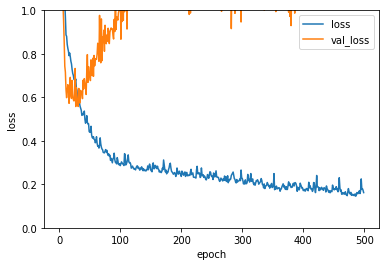

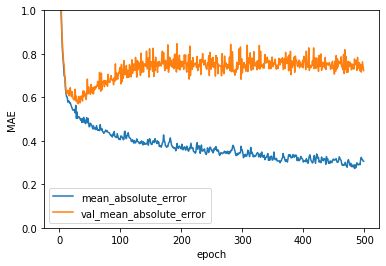

Fold 1
MAE_train = 0.68
MAE_test  = 0.711

Train on 310 samples, validate on 78 samples
Epoch 1/500
310/310 [==============================] - 0s 75us/sample - loss: 0.4202 - mean_absolute_error: 0.4211 - val_loss: 0.1947 - val_mean_absolute_error: 0.3333
Epoch 2/500
310/310 [==============================] - 0s 52us/sample - loss: 0.3458 - mean_absolute_error: 0.4125 - val_loss: 0.3008 - val_mean_absolute_error: 0.3950
Epoch 3/500
310/310 [==============================] - 0s 52us/sample - loss: 0.3616 - mean_absolute_error: 0.4343 - val_loss: 0.2333 - val_mean_absolute_error: 0.3608
Epoch 4/500
310/310 [==============================] - 0s 52us/sample - loss: 0.3443 - mean_absolute_error: 0.4174 - val_loss: 0.2500 - val_mean_absolute_error: 0.3515
Epoch 5/500
310/310 [==============================] - 0s 52us/sample - loss: 0.3687 - mean_absolute_error: 0.4360 - val_loss: 0.2610 - val_mean_absolute_error: 0.3731
Epoch 6/500
310/310 [==============================] - 0s 52us/sample - 

310/310 [==============================] - 0s 52us/sample - loss: 0.2913 - mean_absolute_error: 0.3857 - val_loss: 0.3817 - val_mean_absolute_error: 0.4624
Epoch 50/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2601 - mean_absolute_error: 0.3734 - val_loss: 0.3259 - val_mean_absolute_error: 0.4380
Epoch 51/500
310/310 [==============================] - 0s 51us/sample - loss: 0.2624 - mean_absolute_error: 0.3705 - val_loss: 0.3571 - val_mean_absolute_error: 0.4533
Epoch 52/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2706 - mean_absolute_error: 0.3810 - val_loss: 0.3299 - val_mean_absolute_error: 0.4484
Epoch 53/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2952 - mean_absolute_error: 0.3881 - val_loss: 0.3396 - val_mean_absolute_error: 0.4473
Epoch 54/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2509 - mean_absolute_error: 0.3715 - val_loss: 0.3366 - val_mean_absolute_error: 0.4390

310/310 [==============================] - 0s 52us/sample - loss: 0.2066 - mean_absolute_error: 0.3350 - val_loss: 0.3960 - val_mean_absolute_error: 0.4829
Epoch 98/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2180 - mean_absolute_error: 0.3435 - val_loss: 0.4071 - val_mean_absolute_error: 0.4946
Epoch 99/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2139 - mean_absolute_error: 0.3472 - val_loss: 0.3822 - val_mean_absolute_error: 0.4681
Epoch 100/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2162 - mean_absolute_error: 0.3491 - val_loss: 0.3968 - val_mean_absolute_error: 0.4912
Epoch 101/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2207 - mean_absolute_error: 0.3506 - val_loss: 0.4253 - val_mean_absolute_error: 0.4764
Epoch 102/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2009 - mean_absolute_error: 0.3325 - val_loss: 0.4098 - val_mean_absolute_error: 0.5

310/310 [==============================] - 0s 52us/sample - loss: 0.1795 - mean_absolute_error: 0.3140 - val_loss: 0.3392 - val_mean_absolute_error: 0.4636
Epoch 146/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2083 - mean_absolute_error: 0.3432 - val_loss: 0.4257 - val_mean_absolute_error: 0.4959
Epoch 147/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2155 - mean_absolute_error: 0.3385 - val_loss: 0.3651 - val_mean_absolute_error: 0.4659
Epoch 148/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1890 - mean_absolute_error: 0.3281 - val_loss: 0.4287 - val_mean_absolute_error: 0.4894
Epoch 149/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1838 - mean_absolute_error: 0.3245 - val_loss: 0.4122 - val_mean_absolute_error: 0.4836
Epoch 150/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1917 - mean_absolute_error: 0.3329 - val_loss: 0.4556 - val_mean_absolute_error: 0

Epoch 193/500
310/310 [==============================] - ETA: 0s - loss: 0.1930 - mean_absolute_error: 0.365 - 0s 26us/sample - loss: 0.2128 - mean_absolute_error: 0.3478 - val_loss: 0.3471 - val_mean_absolute_error: 0.4421
Epoch 194/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2053 - mean_absolute_error: 0.3367 - val_loss: 0.3611 - val_mean_absolute_error: 0.4561
Epoch 195/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1728 - mean_absolute_error: 0.3078 - val_loss: 0.3996 - val_mean_absolute_error: 0.4971
Epoch 196/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1857 - mean_absolute_error: 0.3257 - val_loss: 0.3981 - val_mean_absolute_error: 0.4646
Epoch 197/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1675 - mean_absolute_error: 0.3109 - val_loss: 0.3852 - val_mean_absolute_error: 0.4879
Epoch 198/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1793 - mean_ab

310/310 [==============================] - 0s 52us/sample - loss: 0.1790 - mean_absolute_error: 0.3123 - val_loss: 0.3464 - val_mean_absolute_error: 0.4597
Epoch 241/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1778 - mean_absolute_error: 0.3102 - val_loss: 0.3796 - val_mean_absolute_error: 0.4812
Epoch 242/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1939 - mean_absolute_error: 0.3254 - val_loss: 0.3453 - val_mean_absolute_error: 0.4595
Epoch 243/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1914 - mean_absolute_error: 0.3291 - val_loss: 0.4212 - val_mean_absolute_error: 0.4807
Epoch 244/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1834 - mean_absolute_error: 0.3186 - val_loss: 0.4055 - val_mean_absolute_error: 0.4974
Epoch 245/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1848 - mean_absolute_error: 0.3260 - val_loss: 0.3649 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 26us/sample - loss: 0.1603 - mean_absolute_error: 0.2950 - val_loss: 0.3972 - val_mean_absolute_error: 0.4863
Epoch 289/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1576 - mean_absolute_error: 0.2917 - val_loss: 0.3816 - val_mean_absolute_error: 0.4759
Epoch 290/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1564 - mean_absolute_error: 0.2963 - val_loss: 0.4145 - val_mean_absolute_error: 0.4942
Epoch 291/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1720 - mean_absolute_error: 0.3046 - val_loss: 0.4475 - val_mean_absolute_error: 0.5157
Epoch 292/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1738 - mean_absolute_error: 0.3139 - val_loss: 0.3949 - val_mean_absolute_error: 0.4882
Epoch 293/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1697 - mean_absolute_error: 0.3017 - val_loss: 0.3468 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.1615 - mean_absolute_error: 0.3009 - val_loss: 0.3971 - val_mean_absolute_error: 0.4843
Epoch 337/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1594 - mean_absolute_error: 0.2966 - val_loss: 0.4021 - val_mean_absolute_error: 0.4899
Epoch 338/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1590 - mean_absolute_error: 0.2964 - val_loss: 0.4146 - val_mean_absolute_error: 0.4970
Epoch 339/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1571 - mean_absolute_error: 0.2928 - val_loss: 0.3916 - val_mean_absolute_error: 0.4906
Epoch 340/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1570 - mean_absolute_error: 0.2876 - val_loss: 0.4416 - val_mean_absolute_error: 0.5103
Epoch 341/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1691 - mean_absolute_error: 0.3073 - val_loss: 0.3767 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.1696 - mean_absolute_error: 0.3020 - val_loss: 0.4725 - val_mean_absolute_error: 0.5216
Epoch 384/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1683 - mean_absolute_error: 0.3056 - val_loss: 0.5735 - val_mean_absolute_error: 0.5219
Epoch 385/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1686 - mean_absolute_error: 0.3039 - val_loss: 0.4928 - val_mean_absolute_error: 0.5205
Epoch 386/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1558 - mean_absolute_error: 0.2924 - val_loss: 0.4969 - val_mean_absolute_error: 0.5099
Epoch 387/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1687 - mean_absolute_error: 0.3074 - val_loss: 0.5458 - val_mean_absolute_error: 0.5440
Epoch 388/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1710 - mean_absolute_error: 0.3063 - val_loss: 0.5394 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.1566 - mean_absolute_error: 0.2930 - val_loss: 0.5295 - val_mean_absolute_error: 0.5365
Epoch 432/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1512 - mean_absolute_error: 0.2844 - val_loss: 0.5212 - val_mean_absolute_error: 0.5067
Epoch 433/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1729 - mean_absolute_error: 0.3042 - val_loss: 0.5896 - val_mean_absolute_error: 0.5707
Epoch 434/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1797 - mean_absolute_error: 0.3130 - val_loss: 0.4788 - val_mean_absolute_error: 0.5232
Epoch 435/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1508 - mean_absolute_error: 0.2851 - val_loss: 0.5059 - val_mean_absolute_error: 0.5110
Epoch 436/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1555 - mean_absolute_error: 0.2864 - val_loss: 0.5527 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.1494 - mean_absolute_error: 0.2839 - val_loss: 0.5546 - val_mean_absolute_error: 0.5261
Epoch 480/500
310/310 [==============================] - 0s 56us/sample - loss: 0.1475 - mean_absolute_error: 0.2814 - val_loss: 0.5634 - val_mean_absolute_error: 0.5516
Epoch 481/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1466 - mean_absolute_error: 0.2809 - val_loss: 0.5599 - val_mean_absolute_error: 0.5320
Epoch 482/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1452 - mean_absolute_error: 0.2755 - val_loss: 0.5218 - val_mean_absolute_error: 0.5333
Epoch 483/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1509 - mean_absolute_error: 0.2851 - val_loss: 0.5310 - val_mean_absolute_error: 0.5299
Epoch 484/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1511 - mean_absolute_error: 0.2894 - val_loss: 0.5795 - val_mean_absolute_error: 0

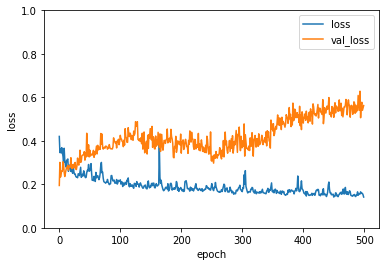

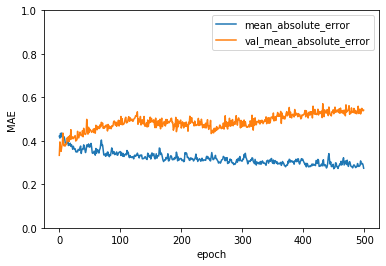

Fold 2
MAE_train = 0.701
MAE_test  = 0.624

Train on 310 samples, validate on 78 samples
Epoch 1/500
310/310 [==============================] - 0s 51us/sample - loss: 0.2643 - mean_absolute_error: 0.3675 - val_loss: 0.1956 - val_mean_absolute_error: 0.3167
Epoch 2/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2136 - mean_absolute_error: 0.3646 - val_loss: 0.2277 - val_mean_absolute_error: 0.3355
Epoch 3/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2162 - mean_absolute_error: 0.3601 - val_loss: 0.2194 - val_mean_absolute_error: 0.3479
Epoch 4/500
310/310 [==============================] - 0s 26us/sample - loss: 0.2107 - mean_absolute_error: 0.3477 - val_loss: 0.2648 - val_mean_absolute_error: 0.3608
Epoch 5/500
310/310 [==============================] - 0s 52us/sample - loss: 0.2051 - mean_absolute_error: 0.3468 - val_loss: 0.1991 - val_mean_absolute_error: 0.3333
Epoch 6/500
310/310 [==============================] - 0s 52us/sample -

Epoch 49/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1695 - mean_absolute_error: 0.3112 - val_loss: 0.2962 - val_mean_absolute_error: 0.3979
Epoch 50/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1684 - mean_absolute_error: 0.3068 - val_loss: 0.3584 - val_mean_absolute_error: 0.4222
Epoch 51/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1797 - mean_absolute_error: 0.3229 - val_loss: 0.4835 - val_mean_absolute_error: 0.4909
Epoch 52/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1725 - mean_absolute_error: 0.3106 - val_loss: 0.4630 - val_mean_absolute_error: 0.4533
Epoch 53/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1887 - mean_absolute_error: 0.3264 - val_loss: 0.4754 - val_mean_absolute_error: 0.4527
Epoch 54/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1741 - mean_absolute_error: 0.3165 - val_loss: 0.4646 - val_mean_absolute_

310/310 [==============================] - 0s 52us/sample - loss: 0.1541 - mean_absolute_error: 0.2925 - val_loss: 0.4738 - val_mean_absolute_error: 0.4937
Epoch 98/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1620 - mean_absolute_error: 0.2993 - val_loss: 0.4983 - val_mean_absolute_error: 0.4905
Epoch 99/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1561 - mean_absolute_error: 0.2997 - val_loss: 0.5097 - val_mean_absolute_error: 0.4852
Epoch 100/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1582 - mean_absolute_error: 0.2900 - val_loss: 0.5047 - val_mean_absolute_error: 0.4993
Epoch 101/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1529 - mean_absolute_error: 0.2895 - val_loss: 0.4714 - val_mean_absolute_error: 0.4800
Epoch 102/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1621 - mean_absolute_error: 0.2966 - val_loss: 0.5397 - val_mean_absolute_error: 0.5

310/310 [==============================] - 0s 52us/sample - loss: 0.1594 - mean_absolute_error: 0.2949 - val_loss: 0.5784 - val_mean_absolute_error: 0.5462
Epoch 146/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1826 - mean_absolute_error: 0.3092 - val_loss: 0.4704 - val_mean_absolute_error: 0.5005
Epoch 147/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1514 - mean_absolute_error: 0.2850 - val_loss: 0.5286 - val_mean_absolute_error: 0.5206
Epoch 148/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1511 - mean_absolute_error: 0.2893 - val_loss: 0.5372 - val_mean_absolute_error: 0.5199
Epoch 149/500
310/310 [==============================] - 0s 51us/sample - loss: 0.1534 - mean_absolute_error: 0.2945 - val_loss: 0.5449 - val_mean_absolute_error: 0.5383
Epoch 150/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1508 - mean_absolute_error: 0.2940 - val_loss: 0.6067 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 52us/sample - loss: 0.1436 - mean_absolute_error: 0.2810 - val_loss: 0.6336 - val_mean_absolute_error: 0.5494
Epoch 193/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1453 - mean_absolute_error: 0.2898 - val_loss: 0.5346 - val_mean_absolute_error: 0.5348
Epoch 194/500
310/310 [==============================] - 0s 77us/sample - loss: 0.1512 - mean_absolute_error: 0.2898 - val_loss: 0.6018 - val_mean_absolute_error: 0.5723
Epoch 195/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1543 - mean_absolute_error: 0.2969 - val_loss: 0.6125 - val_mean_absolute_error: 0.5480
Epoch 196/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1446 - mean_absolute_error: 0.2808 - val_loss: 0.6432 - val_mean_absolute_error: 0.5682
Epoch 197/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1364 - mean_absolute_error: 0.2738 - val_loss: 0.6183 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 78us/sample - loss: 0.1454 - mean_absolute_error: 0.2819 - val_loss: 0.7520 - val_mean_absolute_error: 0.6232
Epoch 241/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1504 - mean_absolute_error: 0.2850 - val_loss: 0.8302 - val_mean_absolute_error: 0.6298
Epoch 242/500
310/310 [==============================] - 0s 77us/sample - loss: 0.1636 - mean_absolute_error: 0.3068 - val_loss: 0.7055 - val_mean_absolute_error: 0.5953
Epoch 243/500
310/310 [==============================] - 0s 56us/sample - loss: 0.1428 - mean_absolute_error: 0.2771 - val_loss: 0.6889 - val_mean_absolute_error: 0.5874
Epoch 244/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1418 - mean_absolute_error: 0.2782 - val_loss: 0.7619 - val_mean_absolute_error: 0.6078
Epoch 245/500
310/310 [==============================] - 0s 77us/sample - loss: 0.1341 - mean_absolute_error: 0.2700 - val_loss: 0.7516 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 26us/sample - loss: 0.1329 - mean_absolute_error: 0.2697 - val_loss: 0.8751 - val_mean_absolute_error: 0.6522
Epoch 288/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1263 - mean_absolute_error: 0.2620 - val_loss: 0.8857 - val_mean_absolute_error: 0.6523
Epoch 289/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1359 - mean_absolute_error: 0.2737 - val_loss: 0.8140 - val_mean_absolute_error: 0.6439
Epoch 290/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1341 - mean_absolute_error: 0.2650 - val_loss: 0.9144 - val_mean_absolute_error: 0.6644
Epoch 291/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1394 - mean_absolute_error: 0.2725 - val_loss: 0.8269 - val_mean_absolute_error: 0.6440
Epoch 292/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1484 - mean_absolute_error: 0.2880 - val_loss: 0.8840 - val_mean_absolute_error: 0

Epoch 335/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1440 - mean_absolute_error: 0.2798 - val_loss: 0.8865 - val_mean_absolute_error: 0.6640
Epoch 336/500
310/310 [==============================] - 0s 77us/sample - loss: 0.1367 - mean_absolute_error: 0.2741 - val_loss: 0.9182 - val_mean_absolute_error: 0.6665
Epoch 337/500
310/310 [==============================] - 0s 55us/sample - loss: 0.1300 - mean_absolute_error: 0.2692 - val_loss: 1.0206 - val_mean_absolute_error: 0.7101
Epoch 338/500
310/310 [==============================] - 0s 107us/sample - loss: 0.1333 - mean_absolute_error: 0.2703 - val_loss: 0.9988 - val_mean_absolute_error: 0.7059
Epoch 339/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1353 - mean_absolute_error: 0.2749 - val_loss: 1.0066 - val_mean_absolute_error: 0.7020
Epoch 340/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1318 - mean_absolute_error: 0.2710 - val_loss: 1.0047 - val_mean_ab

Epoch 383/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1247 - mean_absolute_error: 0.2629 - val_loss: 0.9963 - val_mean_absolute_error: 0.6936
Epoch 384/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1174 - mean_absolute_error: 0.2528 - val_loss: 1.0552 - val_mean_absolute_error: 0.7040
Epoch 385/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1188 - mean_absolute_error: 0.2490 - val_loss: 0.9969 - val_mean_absolute_error: 0.6914
Epoch 386/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1188 - mean_absolute_error: 0.2577 - val_loss: 1.0351 - val_mean_absolute_error: 0.7160
Epoch 387/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1378 - mean_absolute_error: 0.2722 - val_loss: 1.0123 - val_mean_absolute_error: 0.7060
Epoch 388/500
310/310 [==============================] - 0s 26us/sample - loss: 0.1675 - mean_absolute_error: 0.2942 - val_loss: 1.0318 - val_mean_abs

310/310 [==============================] - 0s 52us/sample - loss: 0.1192 - mean_absolute_error: 0.2485 - val_loss: 1.1357 - val_mean_absolute_error: 0.7239
Epoch 432/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1153 - mean_absolute_error: 0.2447 - val_loss: 1.1394 - val_mean_absolute_error: 0.7266
Epoch 433/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1215 - mean_absolute_error: 0.2567 - val_loss: 1.1342 - val_mean_absolute_error: 0.7307
Epoch 434/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1156 - mean_absolute_error: 0.2454 - val_loss: 1.1690 - val_mean_absolute_error: 0.7425
Epoch 435/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1247 - mean_absolute_error: 0.2640 - val_loss: 1.1291 - val_mean_absolute_error: 0.7284
Epoch 436/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1185 - mean_absolute_error: 0.2512 - val_loss: 1.1753 - val_mean_absolute_error: 0

310/310 [==============================] - 0s 77us/sample - loss: 0.1235 - mean_absolute_error: 0.2609 - val_loss: 1.1730 - val_mean_absolute_error: 0.7453
Epoch 479/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1234 - mean_absolute_error: 0.2645 - val_loss: 1.2153 - val_mean_absolute_error: 0.7552
Epoch 480/500
310/310 [==============================] - 0s 77us/sample - loss: 0.1223 - mean_absolute_error: 0.2634 - val_loss: 1.2260 - val_mean_absolute_error: 0.7436
Epoch 481/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1263 - mean_absolute_error: 0.2634 - val_loss: 1.2926 - val_mean_absolute_error: 0.7532
Epoch 482/500
310/310 [==============================] - 0s 77us/sample - loss: 0.1318 - mean_absolute_error: 0.2669 - val_loss: 1.2620 - val_mean_absolute_error: 0.7367
Epoch 483/500
310/310 [==============================] - 0s 52us/sample - loss: 0.1181 - mean_absolute_error: 0.2587 - val_loss: 1.2192 - val_mean_absolute_error: 0

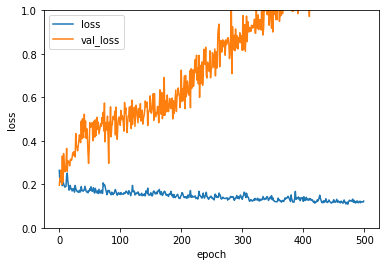

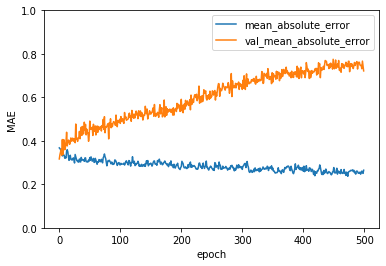

Fold 3
MAE_train = 0.647
MAE_test  = 0.839

Train on 311 samples, validate on 77 samples
Epoch 1/500
311/311 [==============================] - 0s 127us/sample - loss: 0.4641 - mean_absolute_error: 0.4406 - val_loss: 0.2031 - val_mean_absolute_error: 0.3529
Epoch 2/500
311/311 [==============================] - 0s 77us/sample - loss: 0.3866 - mean_absolute_error: 0.4285 - val_loss: 0.2574 - val_mean_absolute_error: 0.4094
Epoch 3/500
311/311 [==============================] - 0s 51us/sample - loss: 0.2335 - mean_absolute_error: 0.3663 - val_loss: 0.2645 - val_mean_absolute_error: 0.4276
Epoch 4/500
311/311 [==============================] - 0s 26us/sample - loss: 0.2108 - mean_absolute_error: 0.3591 - val_loss: 0.2732 - val_mean_absolute_error: 0.4202
Epoch 5/500
311/311 [==============================] - 0s 26us/sample - loss: 0.1937 - mean_absolute_error: 0.3403 - val_loss: 0.2466 - val_mean_absolute_error: 0.3854
Epoch 6/500
311/311 [==============================] - 0s 26us/sample 

Epoch 49/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1436 - mean_absolute_error: 0.2898 - val_loss: 0.4210 - val_mean_absolute_error: 0.4898
Epoch 50/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1385 - mean_absolute_error: 0.2805 - val_loss: 0.3994 - val_mean_absolute_error: 0.4814
Epoch 51/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1339 - mean_absolute_error: 0.2744 - val_loss: 0.4599 - val_mean_absolute_error: 0.5117
Epoch 52/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1367 - mean_absolute_error: 0.2782 - val_loss: 0.3963 - val_mean_absolute_error: 0.4794
Epoch 53/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1382 - mean_absolute_error: 0.2792 - val_loss: 0.5004 - val_mean_absolute_error: 0.5313
Epoch 54/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1335 - mean_absolute_error: 0.2739 - val_loss: 0.4352 - val_mean_absolute_

311/311 [==============================] - 0s 51us/sample - loss: 0.1414 - mean_absolute_error: 0.2717 - val_loss: 0.7354 - val_mean_absolute_error: 0.5949
Epoch 98/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1326 - mean_absolute_error: 0.2702 - val_loss: 0.7289 - val_mean_absolute_error: 0.5850
Epoch 99/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1516 - mean_absolute_error: 0.2805 - val_loss: 0.7703 - val_mean_absolute_error: 0.6081
Epoch 100/500
311/311 [==============================] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.222 - 0s 51us/sample - loss: 0.1360 - mean_absolute_error: 0.2760 - val_loss: 0.7539 - val_mean_absolute_error: 0.6008
Epoch 101/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1549 - mean_absolute_error: 0.2927 - val_loss: 0.7525 - val_mean_absolute_error: 0.6014
Epoch 102/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1408 - mean_absolute_error: 0.

Epoch 145/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1390 - mean_absolute_error: 0.2767 - val_loss: 0.8843 - val_mean_absolute_error: 0.6388
Epoch 146/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1321 - mean_absolute_error: 0.2653 - val_loss: 0.9019 - val_mean_absolute_error: 0.6421
Epoch 147/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1513 - mean_absolute_error: 0.2773 - val_loss: 0.8745 - val_mean_absolute_error: 0.6315
Epoch 148/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1313 - mean_absolute_error: 0.2634 - val_loss: 0.9571 - val_mean_absolute_error: 0.6612
Epoch 149/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1234 - mean_absolute_error: 0.2582 - val_loss: 0.8940 - val_mean_absolute_error: 0.6435
Epoch 150/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1449 - mean_absolute_error: 0.2756 - val_loss: 0.8665 - val_mean_abs

311/311 [==============================] - 0s 51us/sample - loss: 0.1368 - mean_absolute_error: 0.2772 - val_loss: 0.9467 - val_mean_absolute_error: 0.6521
Epoch 194/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1395 - mean_absolute_error: 0.2750 - val_loss: 1.0486 - val_mean_absolute_error: 0.6690
Epoch 195/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1377 - mean_absolute_error: 0.2762 - val_loss: 0.9925 - val_mean_absolute_error: 0.6717
Epoch 196/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1557 - mean_absolute_error: 0.2936 - val_loss: 1.0126 - val_mean_absolute_error: 0.6866
Epoch 197/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1306 - mean_absolute_error: 0.2638 - val_loss: 0.9744 - val_mean_absolute_error: 0.6706
Epoch 198/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1372 - mean_absolute_error: 0.2730 - val_loss: 1.0442 - val_mean_absolute_error: 0

Epoch 241/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1167 - mean_absolute_error: 0.2483 - val_loss: 1.0594 - val_mean_absolute_error: 0.6934
Epoch 242/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1261 - mean_absolute_error: 0.2553 - val_loss: 1.0464 - val_mean_absolute_error: 0.6944
Epoch 243/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1270 - mean_absolute_error: 0.2555 - val_loss: 1.1047 - val_mean_absolute_error: 0.7114
Epoch 244/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1220 - mean_absolute_error: 0.2529 - val_loss: 1.0421 - val_mean_absolute_error: 0.6840
Epoch 245/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1244 - mean_absolute_error: 0.2534 - val_loss: 1.0818 - val_mean_absolute_error: 0.7013
Epoch 246/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1364 - mean_absolute_error: 0.2605 - val_loss: 1.0478 - val_mean_abs

311/311 [==============================] - 0s 52us/sample - loss: 0.1365 - mean_absolute_error: 0.2693 - val_loss: 1.1542 - val_mean_absolute_error: 0.7294
Epoch 290/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1291 - mean_absolute_error: 0.2643 - val_loss: 1.1800 - val_mean_absolute_error: 0.7345
Epoch 291/500
311/311 [==============================] - ETA: 0s - loss: 0.0865 - mean_absolute_error: 0.198 - 0s 51us/sample - loss: 0.1621 - mean_absolute_error: 0.2891 - val_loss: 1.1021 - val_mean_absolute_error: 0.7257
Epoch 292/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1460 - mean_absolute_error: 0.2877 - val_loss: 1.1177 - val_mean_absolute_error: 0.7171
Epoch 293/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1365 - mean_absolute_error: 0.2816 - val_loss: 1.0863 - val_mean_absolute_error: 0.7177
Epoch 294/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1385 - mean_absolute_error: 

311/311 [==============================] - 0s 52us/sample - loss: 0.1380 - mean_absolute_error: 0.2667 - val_loss: 1.1894 - val_mean_absolute_error: 0.7489
Epoch 337/500
311/311 [==============================] - 0s 77us/sample - loss: 0.1318 - mean_absolute_error: 0.2632 - val_loss: 1.1614 - val_mean_absolute_error: 0.7328
Epoch 338/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1170 - mean_absolute_error: 0.2456 - val_loss: 1.1331 - val_mean_absolute_error: 0.7178
Epoch 339/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1218 - mean_absolute_error: 0.2519 - val_loss: 1.1704 - val_mean_absolute_error: 0.7507
Epoch 340/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1149 - mean_absolute_error: 0.2461 - val_loss: 1.1479 - val_mean_absolute_error: 0.7156
Epoch 341/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1194 - mean_absolute_error: 0.2468 - val_loss: 1.1570 - val_mean_absolute_error: 0

311/311 [==============================] - 0s 52us/sample - loss: 0.1176 - mean_absolute_error: 0.2443 - val_loss: 1.2015 - val_mean_absolute_error: 0.7373
Epoch 385/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1182 - mean_absolute_error: 0.2441 - val_loss: 1.2002 - val_mean_absolute_error: 0.7443
Epoch 386/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1115 - mean_absolute_error: 0.2393 - val_loss: 1.1677 - val_mean_absolute_error: 0.7375
Epoch 387/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1154 - mean_absolute_error: 0.2496 - val_loss: 1.1989 - val_mean_absolute_error: 0.7379
Epoch 388/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1172 - mean_absolute_error: 0.2494 - val_loss: 1.1968 - val_mean_absolute_error: 0.7430
Epoch 389/500
311/311 [==============================] - 0s 26us/sample - loss: 0.1157 - mean_absolute_error: 0.2449 - val_loss: 1.2257 - val_mean_absolute_error: 0

311/311 [==============================] - 0s 51us/sample - loss: 0.1187 - mean_absolute_error: 0.2526 - val_loss: 1.1763 - val_mean_absolute_error: 0.7420
Epoch 433/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1159 - mean_absolute_error: 0.2448 - val_loss: 1.1562 - val_mean_absolute_error: 0.7281
Epoch 434/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1174 - mean_absolute_error: 0.2481 - val_loss: 1.2268 - val_mean_absolute_error: 0.7705
Epoch 435/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1182 - mean_absolute_error: 0.2458 - val_loss: 1.1987 - val_mean_absolute_error: 0.7338
Epoch 436/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1432 - mean_absolute_error: 0.2841 - val_loss: 1.2311 - val_mean_absolute_error: 0.7585
Epoch 437/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1326 - mean_absolute_error: 0.2612 - val_loss: 1.2347 - val_mean_absolute_error: 0

311/311 [==============================] - 0s 51us/sample - loss: 0.1275 - mean_absolute_error: 0.2529 - val_loss: 1.2362 - val_mean_absolute_error: 0.7711
Epoch 481/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1242 - mean_absolute_error: 0.2652 - val_loss: 1.2407 - val_mean_absolute_error: 0.7503
Epoch 482/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1200 - mean_absolute_error: 0.2528 - val_loss: 1.2518 - val_mean_absolute_error: 0.7811
Epoch 483/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1209 - mean_absolute_error: 0.2569 - val_loss: 1.2321 - val_mean_absolute_error: 0.7556
Epoch 484/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1188 - mean_absolute_error: 0.2504 - val_loss: 1.1961 - val_mean_absolute_error: 0.7561
Epoch 485/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1147 - mean_absolute_error: 0.2467 - val_loss: 1.2703 - val_mean_absolute_error: 0

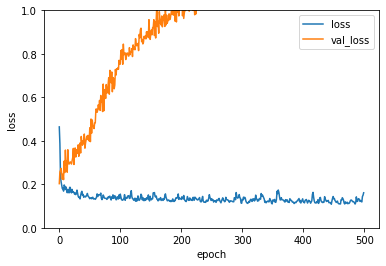

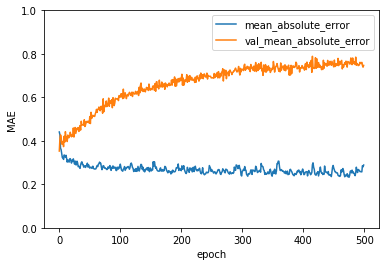

Fold 4
MAE_train = 0.69
MAE_test  = 0.668

Train on 311 samples, validate on 77 samples
Epoch 1/500
311/311 [==============================] - 0s 62us/sample - loss: 0.4538 - mean_absolute_error: 0.4224 - val_loss: 0.2393 - val_mean_absolute_error: 0.3616
Epoch 2/500
311/311 [==============================] - 0s 19us/sample - loss: 0.3573 - mean_absolute_error: 0.4276 - val_loss: 0.2990 - val_mean_absolute_error: 0.3775
Epoch 3/500
311/311 [==============================] - 0s 66us/sample - loss: 0.2810 - mean_absolute_error: 0.3951 - val_loss: 0.3219 - val_mean_absolute_error: 0.4049
Epoch 4/500
311/311 [==============================] - 0s 26us/sample - loss: 0.2457 - mean_absolute_error: 0.3840 - val_loss: 0.2489 - val_mean_absolute_error: 0.3592
Epoch 5/500
311/311 [==============================] - 0s 26us/sample - loss: 0.2384 - mean_absolute_error: 0.3806 - val_loss: 0.2494 - val_mean_absolute_error: 0.3723
Epoch 6/500
311/311 [==============================] - 0s 51us/sample - 

Epoch 49/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1819 - mean_absolute_error: 0.3160 - val_loss: 0.4076 - val_mean_absolute_error: 0.4304
Epoch 50/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1779 - mean_absolute_error: 0.3210 - val_loss: 0.4367 - val_mean_absolute_error: 0.4540
Epoch 51/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1713 - mean_absolute_error: 0.3182 - val_loss: 0.3501 - val_mean_absolute_error: 0.4077
Epoch 52/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1551 - mean_absolute_error: 0.2956 - val_loss: 0.3725 - val_mean_absolute_error: 0.4096
Epoch 53/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1718 - mean_absolute_error: 0.3140 - val_loss: 0.4087 - val_mean_absolute_error: 0.4370
Epoch 54/500
311/311 [==============================] - 0s 77us/sample - loss: 0.1487 - mean_absolute_error: 0.2946 - val_loss: 0.3978 - val_mean_absolute_

311/311 [==============================] - 0s 51us/sample - loss: 0.1399 - mean_absolute_error: 0.2879 - val_loss: 0.4306 - val_mean_absolute_error: 0.4387
Epoch 98/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1426 - mean_absolute_error: 0.2790 - val_loss: 0.4463 - val_mean_absolute_error: 0.4568
Epoch 99/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1814 - mean_absolute_error: 0.3208 - val_loss: 0.6371 - val_mean_absolute_error: 0.5482
Epoch 100/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1648 - mean_absolute_error: 0.3136 - val_loss: 0.4137 - val_mean_absolute_error: 0.4332
Epoch 101/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1606 - mean_absolute_error: 0.3080 - val_loss: 0.4401 - val_mean_absolute_error: 0.4654
Epoch 102/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1611 - mean_absolute_error: 0.3064 - val_loss: 0.4515 - val_mean_absolute_error: 0.4

311/311 [==============================] - 0s 51us/sample - loss: 0.1265 - mean_absolute_error: 0.2688 - val_loss: 0.5147 - val_mean_absolute_error: 0.4814
Epoch 146/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1352 - mean_absolute_error: 0.2757 - val_loss: 0.4706 - val_mean_absolute_error: 0.4674
Epoch 147/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1440 - mean_absolute_error: 0.2814 - val_loss: 0.4780 - val_mean_absolute_error: 0.4729
Epoch 148/500
311/311 [==============================] - 0s 77us/sample - loss: 0.1528 - mean_absolute_error: 0.2967 - val_loss: 0.4545 - val_mean_absolute_error: 0.4457
Epoch 149/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1510 - mean_absolute_error: 0.2917 - val_loss: 0.5104 - val_mean_absolute_error: 0.4804
Epoch 150/500
311/311 [==============================] - ETA: 0s - loss: 0.0921 - mean_absolute_error: 0.264 - 0s 51us/sample - loss: 0.1371 - mean_absolute_error: 

311/311 [==============================] - 0s 52us/sample - loss: 0.1244 - mean_absolute_error: 0.2703 - val_loss: 0.5518 - val_mean_absolute_error: 0.4993
Epoch 193/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1218 - mean_absolute_error: 0.2607 - val_loss: 0.5086 - val_mean_absolute_error: 0.4820
Epoch 194/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1298 - mean_absolute_error: 0.2738 - val_loss: 0.5186 - val_mean_absolute_error: 0.4893
Epoch 195/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1324 - mean_absolute_error: 0.2762 - val_loss: 0.4943 - val_mean_absolute_error: 0.4635
Epoch 196/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1275 - mean_absolute_error: 0.2698 - val_loss: 0.5675 - val_mean_absolute_error: 0.4955
Epoch 197/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1344 - mean_absolute_error: 0.2793 - val_loss: 0.5039 - val_mean_absolute_error: 0

311/311 [==============================] - 0s 55us/sample - loss: 0.1188 - mean_absolute_error: 0.2601 - val_loss: 0.5889 - val_mean_absolute_error: 0.5084
Epoch 241/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1228 - mean_absolute_error: 0.2563 - val_loss: 0.5765 - val_mean_absolute_error: 0.5054
Epoch 242/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1235 - mean_absolute_error: 0.2668 - val_loss: 0.5895 - val_mean_absolute_error: 0.5090
Epoch 243/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1214 - mean_absolute_error: 0.2597 - val_loss: 0.5860 - val_mean_absolute_error: 0.5069
Epoch 244/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1276 - mean_absolute_error: 0.2687 - val_loss: 0.6017 - val_mean_absolute_error: 0.5221
Epoch 245/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1355 - mean_absolute_error: 0.2808 - val_loss: 0.5575 - val_mean_absolute_error: 0

311/311 [==============================] - 0s 52us/sample - loss: 0.1626 - mean_absolute_error: 0.3013 - val_loss: 0.6224 - val_mean_absolute_error: 0.5240
Epoch 288/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1720 - mean_absolute_error: 0.2993 - val_loss: 0.6531 - val_mean_absolute_error: 0.5194
Epoch 289/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1843 - mean_absolute_error: 0.3264 - val_loss: 0.6573 - val_mean_absolute_error: 0.5458
Epoch 290/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1594 - mean_absolute_error: 0.3028 - val_loss: 0.5891 - val_mean_absolute_error: 0.4976
Epoch 291/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1325 - mean_absolute_error: 0.2767 - val_loss: 0.6068 - val_mean_absolute_error: 0.5222
Epoch 292/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1291 - mean_absolute_error: 0.2696 - val_loss: 0.5987 - val_mean_absolute_error: 0

311/311 [==============================] - 0s 52us/sample - loss: 0.1217 - mean_absolute_error: 0.2642 - val_loss: 0.6689 - val_mean_absolute_error: 0.5262
Epoch 336/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1180 - mean_absolute_error: 0.2537 - val_loss: 0.6041 - val_mean_absolute_error: 0.5053
Epoch 337/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1283 - mean_absolute_error: 0.2635 - val_loss: 0.6799 - val_mean_absolute_error: 0.5348
Epoch 338/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1212 - mean_absolute_error: 0.2611 - val_loss: 0.6312 - val_mean_absolute_error: 0.5121
Epoch 339/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1201 - mean_absolute_error: 0.2582 - val_loss: 0.6305 - val_mean_absolute_error: 0.5152
Epoch 340/500
311/311 [==============================] - 0s 77us/sample - loss: 0.1145 - mean_absolute_error: 0.2473 - val_loss: 0.6316 - val_mean_absolute_error: 0

311/311 [==============================] - 0s 77us/sample - loss: 0.1215 - mean_absolute_error: 0.2529 - val_loss: 0.6829 - val_mean_absolute_error: 0.5323
Epoch 384/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1154 - mean_absolute_error: 0.2536 - val_loss: 0.6421 - val_mean_absolute_error: 0.5291
Epoch 385/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1222 - mean_absolute_error: 0.2591 - val_loss: 0.6790 - val_mean_absolute_error: 0.5161
Epoch 386/500
311/311 [==============================] - 0s 55us/sample - loss: 0.1230 - mean_absolute_error: 0.2636 - val_loss: 0.6152 - val_mean_absolute_error: 0.5162
Epoch 387/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1246 - mean_absolute_error: 0.2665 - val_loss: 0.6620 - val_mean_absolute_error: 0.5167
Epoch 388/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1202 - mean_absolute_error: 0.2567 - val_loss: 0.6295 - val_mean_absolute_error: 0

311/311 [==============================] - 0s 52us/sample - loss: 0.1232 - mean_absolute_error: 0.2578 - val_loss: 0.7351 - val_mean_absolute_error: 0.5473
Epoch 432/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1205 - mean_absolute_error: 0.2537 - val_loss: 0.7149 - val_mean_absolute_error: 0.5406
Epoch 433/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1199 - mean_absolute_error: 0.2584 - val_loss: 0.7444 - val_mean_absolute_error: 0.5503
Epoch 434/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1246 - mean_absolute_error: 0.2644 - val_loss: 0.7093 - val_mean_absolute_error: 0.5619
Epoch 435/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1275 - mean_absolute_error: 0.2678 - val_loss: 0.7086 - val_mean_absolute_error: 0.5109
Epoch 436/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1313 - mean_absolute_error: 0.2734 - val_loss: 0.7321 - val_mean_absolute_error: 0

311/311 [==============================] - 0s 51us/sample - loss: 0.1100 - mean_absolute_error: 0.2454 - val_loss: 0.7809 - val_mean_absolute_error: 0.5582
Epoch 480/500
311/311 [==============================] - 0s 77us/sample - loss: 0.1156 - mean_absolute_error: 0.2545 - val_loss: 0.8474 - val_mean_absolute_error: 0.5780
Epoch 481/500
311/311 [==============================] - 0s 52us/sample - loss: 0.1174 - mean_absolute_error: 0.2491 - val_loss: 0.8345 - val_mean_absolute_error: 0.5682
Epoch 482/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1140 - mean_absolute_error: 0.2500 - val_loss: 0.7992 - val_mean_absolute_error: 0.5513
Epoch 483/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1127 - mean_absolute_error: 0.2517 - val_loss: 0.8302 - val_mean_absolute_error: 0.5712
Epoch 484/500
311/311 [==============================] - 0s 51us/sample - loss: 0.1112 - mean_absolute_error: 0.2434 - val_loss: 0.8417 - val_mean_absolute_error: 0

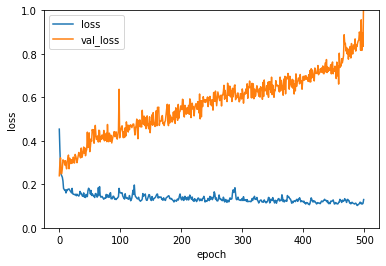

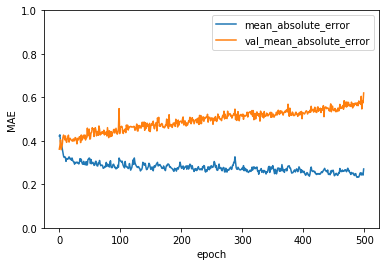

Fold 5
MAE_train = 0.711
MAE_test  = 0.585

Cross Validation MAE = 0.686


In [23]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

#モデル作成
model = Sequential()
model.add(Dense(12, activation='tanh', input_dim=8))
model.add(Dense(6, activation='tanh', input_dim=12))
model.add(Dense(1, activation='linear'))

# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])


#交差検証法
from sklearn.model_selection import KFold # 交差検証法に関する関数

n_split = 5 # グループ数を設定（5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    #訓練データの説明変数を標準化
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    stdsc = StandardScaler()
    X_train_std= stdsc.fit_transform(X_train)
    
    #テストデータの説明変数を標準化
    X_test_std= stdsc.transform(X_test)   

    # 学習用データを使ってニューラルネットワークモデルを学習
    fit = model.fit(X_train_std, y_train,
          epochs=500,
          batch_size=20,validation_data=(X_test_std, y_test))

    # 各epochにおける損失と精度をdfに入れる
    df = pd.DataFrame(fit.history)
    # グラフ化
    df[["loss", "val_loss"]].plot()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim([0,1.0])
    plt.show()
    
    df[["mean_absolute_error", "val_mean_absolute_error"]].plot()
    plt.ylabel("MAE")
    plt.xlabel("epoch")
    plt.ylim([0,1.0])
    plt.show()
    
    # 予測を実行
    y_pred_train = regr.predict(X_train)
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE_train = %s"%round(mae_train, 3))
    print("MAE_test  = %s"%round(mae_test, 3))
    print()
    
    cross_valid_mae += mae_test #後で平均を取るためにMAEを加算
    split_num += 1
    
# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

### 訓練誤差と汎化誤差に差があり過学習がおきている
### MAEが0.686で線形回帰と同等

### ７．まとめ

|モデル|MAE|
|:-|:-|
|線形回帰|0.631|
|ランダムフォレスト|0.44|
|ニューラルネットワーク|0.686|

#### ランダムフォレストが最も誤差が少なく予測が可能